<a href="https://colab.research.google.com/github/prathiksha9481/The-farmbot-project/blob/main/Cotton_Disease_Recognition_02_Sigmoid_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!dir

drive  sample_data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import os
import cv2
from imutils import paths
from tqdm import tqdm_notebook as tqdm
import itertools
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
os.chdir("/content/drive/MyDrive/Cotton_Disease")

In [ ]:
!dir

augmented  Cotton_Disease_Recognition_02_Sigmoid_VGG16.ipynb


In [ ]:
def import_images(IMGDIR, imgsize):
    print("[WIP] Images are being unpacked...")
    data = []
    labels = []

    imagepaths = sorted(list(paths.list_images(IMGDIR)))
    random.seed(42)
    random.shuffle(imagepaths)

    with tqdm(total=len(imagepaths)) as pro_bar:  #to display progress of unpacking the images

        for index, imgpath in enumerate(imagepaths):

            try:
                img = cv2.imread(imgpath)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # AlexNet requires RGB ordering
                img = cv2.resize(img, ( imgsize,imgsize))  # AlexNet require image size 224 x 224 x 3

            except:
                continue

            img = img_to_array(img)
            data.append(img)
            

            label = imgpath.split(os.path.sep)[-2]
            labels.append(label)

            pro_bar.update(1)
    
    data = np.array(data, dtype="float")/255.0
    labels = np.array(list(map(int, labels)))
    return data, labels

In [ ]:
data, labels = import_images("augmented", 224)

[WIP] Images are being unpacked...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/794 [00:00<?, ?it/s]

In [ ]:
classes = ["Healthy", "Boll Rot", "Leafhopper Jassids", "Leaf Redenning","Rust of Cotton", "Wet Weather Blight", "White Flies"]

In [ ]:
def disp_img(i):
    samp_img = np.array(data[i]*255.0, dtype="int")
    samp_lab= classes[labels[i]]
    plt.imshow(samp_img)
    print("Class : ", samp_lab)

Class :  Leafhopper Jassids


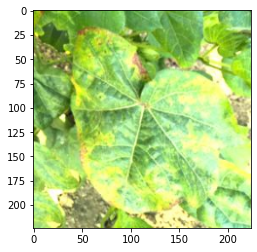

In [ ]:
disp_img(3)

In [ ]:
# Splitting data into train and test with 70% and 30% respectively
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape,'\n',X_test.shape)

(635, 224, 224, 3) 
 (159, 224, 224, 3)


## Model Building Sigmoid and Transfer Learning using VGG16

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Activation, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

In [ ]:
# Build a Model
print("[WIP] Building model...")
n_classes = 7
baseModel = VGG16(weights="imagenet", include_top=False,
              input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(n_classes, activation="sigmoid")(headModel)

cnn_vgg16model = Model(inputs=baseModel.input, outputs=headModel)
print("[Done]")
print(cnn_vgg16model.summary())

[WIP] Building model...
[Done]
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D) 

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
# Compile the model
print("[WIP] Compiling Model...")
cnn_vgg16model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("[Done]")

[WIP] Compiling Model...
[Done]


In [ ]:
cnn_vgg16model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
history_cnnvgg16 = cnn_vgg16model.fit(X_train, Y_train, batch_size=32, epochs=20, validation_data=(X_test, Y_test))

Epoch 1/20
20/20 [==============================] - 45s 2s/step - loss: 3.5437 - accuracy: 0.1969 - val_loss: 1.6267 - val_accuracy: 0.3648
Epoch 2/20
20/20 [==============================] - 4s 188ms/step - loss: 1.6377 - accuracy: 0.3465 - val_loss: 1.2642 - val_accuracy: 0.6164
Epoch 3/20
20/20 [==============================] - 4s 188ms/step - loss: 1.1578 - accuracy: 0.5685 - val_loss: 0.9554 - val_accuracy: 0.7107
Epoch 4/20
20/20 [==============================] - 4s 190ms/step - loss: 0.8874 - accuracy: 0.6913 - val_loss: 0.7676 - val_accuracy: 0.7296
Epoch 5/20
20/20 [==============================] - 4s 190ms/step - loss: 0.6747 - accuracy: 0.7685 - val_loss: 0.5994 - val_accuracy: 0.7862
Epoch 6/20
20/20 [==============================] - 4s 190ms/step - loss: 0.4702 - accuracy: 0.8252 - val_loss: 0.3777 - val_accuracy: 0.9182
Epoch 7/20
20/20 [==============================] - 4s 190ms/step - loss: 0.3852 - accuracy: 0.8661 - val_loss: 0.4006 - val_accuracy: 0.8868
Epoch 8/

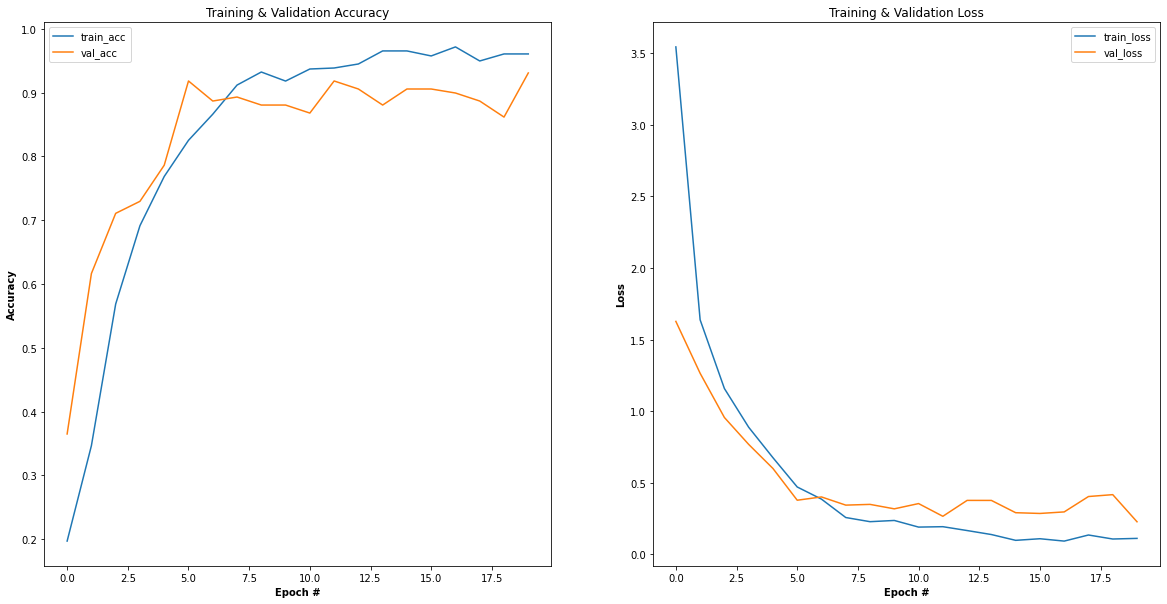

In [ ]:
# Plot the Training and Validation Accuracy and Loss for Alexnet
N = np.arange(0,20)

fig, ax = plt.subplots(1,2, figsize = [20,10])
ax = ax.ravel()

ax[0].plot(N, history_cnnvgg16.history["accuracy"], label = "train_acc")
ax[0].plot(N, history_cnnvgg16.history["val_accuracy"], label = "val_acc")
ax[0].set_title("Training & Validation Accuracy")
ax[0].set_xlabel("Epoch #", weight = "bold")
ax[0].set_ylabel("Accuracy", weight = "bold")
ax[0].legend()

ax[1].plot(N, history_cnnvgg16.history["loss"], label = "train_loss")
ax[1].plot(N, history_cnnvgg16.history["val_loss"], label = "val_loss")
ax[1].set_title("Training & Validation Loss")
ax[1].set_xlabel("Epoch #", weight = "bold")
ax[1].set_ylabel("Loss", weight = "bold")
ax[1].legend()

In [ ]:
# Making Predictions
Y_Pred = cnn_vgg16model.predict(X_test)
Y_Pred

array([[0.03953697, 0.7595173 , 0.46206066, ..., 0.05782535, 0.1303454 ,
        0.9997967 ],
       [0.9609315 , 0.15346517, 0.4846627 , ..., 0.2624735 , 0.40529138,
        0.24792475],
       [0.01581395, 0.07781135, 0.25177175, ..., 0.9970074 , 0.43757457,
        0.91713756],
       ...,
       [0.1574921 , 0.15274233, 0.02089213, ..., 0.9999974 , 0.530913  ,
        0.16898836],
       [0.00117952, 0.99999964, 0.04829141, ..., 0.0411788 , 0.34382278,
        0.19382   ],
       [0.25278544, 0.27932566, 0.40326077, ..., 0.99440867, 0.34214553,
        0.21162307]], dtype=float32)

In [ ]:
# Getting classes with highest probability
Y_Pred_Classes = np.array([np.argmax(i) for i in Y_Pred])
Y_Pred_Classes

array([6, 0, 4, 4, 2, 0, 0, 1, 3, 5, 6, 5, 4, 0, 0, 5, 1, 2, 2, 2, 1, 3,
       4, 3, 0, 1, 5, 0, 1, 0, 6, 1, 6, 3, 1, 3, 1, 2, 6, 4, 1, 0, 4, 2,
       5, 2, 6, 1, 5, 2, 3, 5, 0, 5, 1, 2, 5, 1, 4, 4, 5, 4, 3, 2, 1, 0,
       1, 2, 3, 5, 2, 3, 2, 2, 6, 5, 2, 4, 2, 3, 5, 4, 5, 6, 0, 1, 0, 1,
       1, 4, 1, 2, 1, 4, 6, 0, 3, 0, 5, 4, 3, 4, 3, 5, 5, 1, 2, 0, 0, 1,
       2, 1, 1, 2, 1, 0, 5, 1, 0, 6, 3, 2, 2, 3, 5, 5, 5, 0, 5, 5, 5, 5,
       1, 6, 2, 6, 4, 3, 6, 3, 1, 0, 0, 2, 4, 0, 5, 1, 1, 4, 1, 5, 0, 2,
       0, 2, 4, 1, 4])

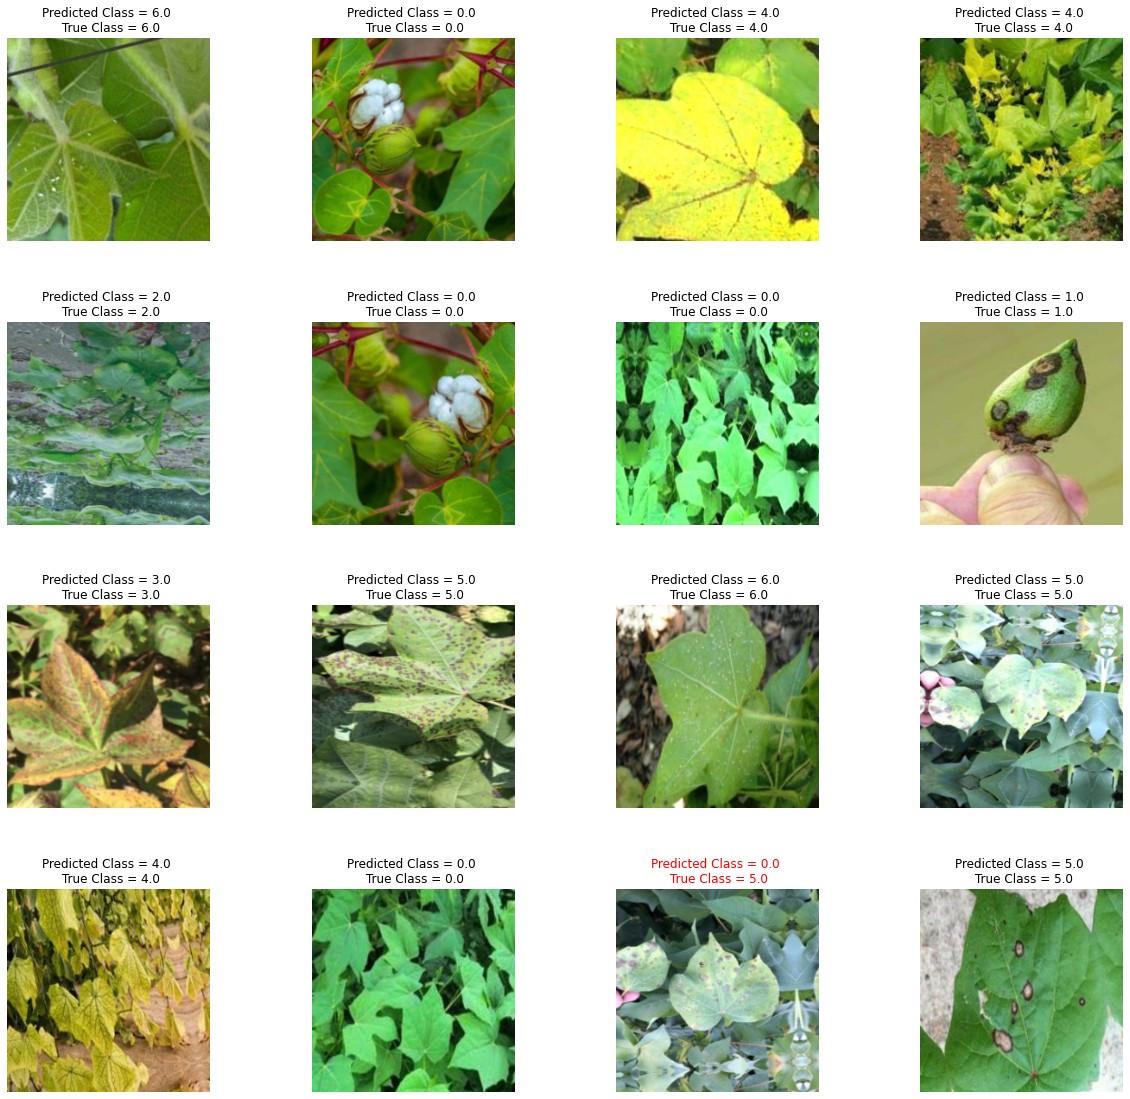

In [ ]:
# Sample Prediction visualisation
# We will create a grid of images with their true label and predicted label.
l=4
w=4

fig, axes = plt.subplots(l, w, figsize=(20,20))
axes = axes.ravel()

for i in np.arange(0, l*w) :
    axes[i].imshow(np.array(X_test[i]*255.0, dtype="int"))
    if Y_test[i] == Y_Pred_Classes[i]:
                   axes[i].set_title('Predicted Class = {:.1f} \n True Class = {:.1f}'.format(Y_Pred_Classes[i], Y_test[i]))
    else :
                   axes[i].set_title('Predicted Class = {:.1f} \n True Class = {:.1f}'.format(Y_Pred_Classes[i], Y_test[i]), color="red")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

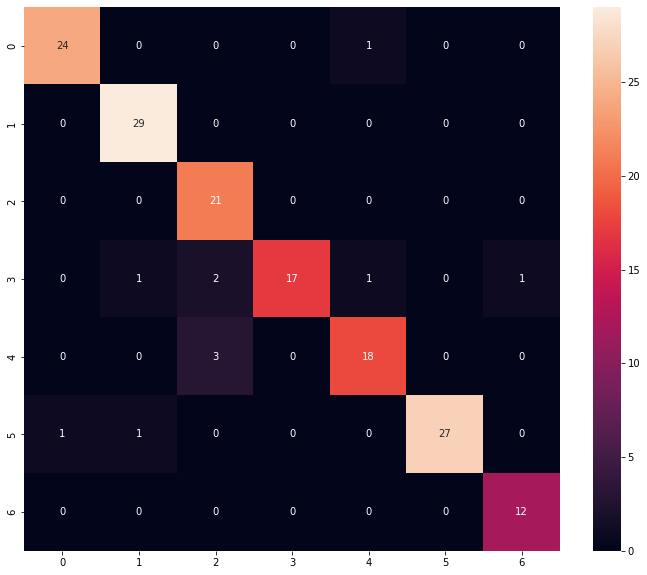

In [ ]:
# Confusion Matrix
cm = confusion_matrix(Y_test, Y_Pred_Classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# Classification Report
print("Classification Report")
print(classification_report(Y_test, Y_Pred_Classes))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       0.94      1.00      0.97        29
           2       0.81      1.00      0.89        21
           3       1.00      0.77      0.87        22
           4       0.90      0.86      0.88        21
           5       1.00      0.93      0.96        29
           6       0.92      1.00      0.96        12

    accuracy                           0.93       159
   macro avg       0.93      0.93      0.93       159
weighted avg       0.94      0.93      0.93       159



In [ ]:
# Accuracy Score
acc=accuracy_score(Y_test, Y_Pred_Classes)
print("The accuracy of the CNN model : {:.2f} % ".format(acc*100))

The accuracy of the CNN model : 93.08 % 


In [ ]:
# Save the model
cnn_vgg16model.save('CNN__VGG16Sig_CLD.h5')
print('Model Saved')

Model Saved


## Short Time Deploymeny (Gradio)

In [ ]:
!dir

augmented	      Cotton_Disease_Recognition_02_Sigmoid_VGG16.ipynb
CNN__VGG16Sig_CLD.h5  flagged


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Cotton_Disease")

In [ ]:
!dir

augmented	      Cotton_Disease_Recognition_02_Sigmoid_VGG16.ipynb
CNN__VGG16Sig_CLD.h5  flagged


In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 4.3 MB/s 
     |████████████████████████████████| 212 kB 53.8 MB/s 
     |████████████████████████████████| 275 kB 55.1 MB/s 
     |████████████████████████████████| 141 kB 55.2 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 57 kB 5.7 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 2.3 MB 50.5 MB/s 
     |████████████████████████████████| 84 kB 3.2 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 80 kB 5.0 MB/s 
     |████████████████████████████████| 68 kB 7.5 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 4.1 MB 51.6 MB/s 
     |████████████████████████████████| 62 kB 1.2 

In [ ]:
# # Import packages and model 
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
import pickle
import cv2
import imutils
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import img_to_array

# Load the model
modelcnn = load_model('CNN__VGG16Sig_CLD.h5')
modelcnn.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
def predict_image(image):

    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # scale values from range 0-255 to 0-1
    image = image.astype("float") / 255.0

    # Ready the image for input to the network
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # make prediction on the image
    preds = modelcnn.predict(image)[0]
    result = dict()
    thres = 0.75
    for i in range(7):
      if preds[i] > thres :
        result[classes[i]] = round(float(list(preds)[i]), 3)
    
    return result

In [ ]:
im = gr.inputs.Image(shape= (224, 224))
label = gr.outputs.Label(num_top_classes=2)
classes = ["Healthy", "Boll Rot", "Leafhopper Jassids", "Leaf Redenning","Rust of Cotton", "Wet Weather Blight", "White Flies"]
gr.Interface(fn = predict_image, inputs = im, outputs = label, capture_session=True, title = "CNN Cotton Leaf Disease Recognition").launch(share=True)

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://59460.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f0600255190>,
 'http://127.0.0.1:7860/',
 'https://59460.gradio.app')

### Save Tflite model


In [ ]:
import tensorflow as tf


In [ ]:
tf.__version__

'2.8.2'

In [ ]:
model_cnn_vgg16 = tf.keras.models.load_model('CNN__VGG16Sig_CLD.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_vgg16)
model_cnnvgg16tflite = converter.convert()
open("cnnvgg16_model.tflite", "wb").write(model_cnnvgg16tflite)

84693832

In [ ]:
!dir

augmented	       Cotton_Disease_Recognition_02_Sigmoid_VGG16.ipynb
cnnvgg16_model.tflite  flagged
CNN__VGG16Sig_CLD.h5


In [ ]:
result = {"Healthy":78.98, "Woll":98.76}

In [ ]:
result

{'Healthy': 78.98, 'Woll': 98.76}

In [ ]:
img_text = max(result.items(), key=lambda k:k[1])

In [ ]:
img_text

('Woll', 98.76)

In [ ]:
result = dict(sorted(result.items(), reverse=True))

In [ ]:
result

{'Healthy': 78.98, 'Wet': 98.76}